Distribuição das classes em nivel_ia_encoded:
 nivel_ia_encoded
3    41
0     2
2     2
1     1
Name: count, dtype: int64
Árvore da Random Forest salva como 'arvore_random_forest.png'


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


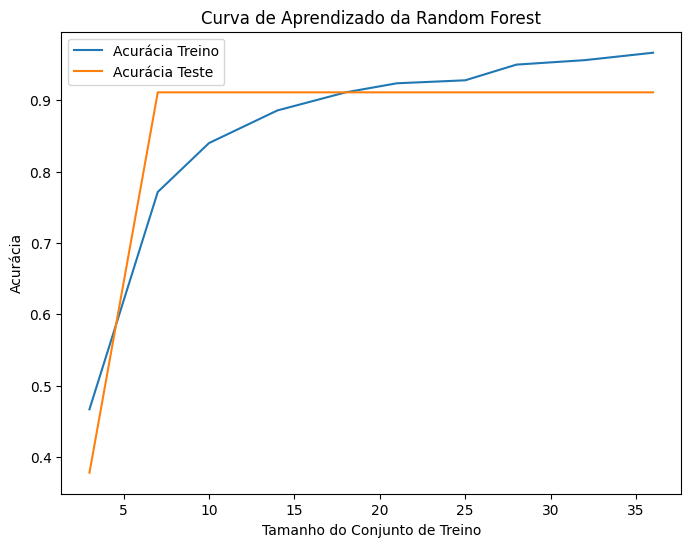

Gráfico de dispersão não gerado: 'python' ou 'QT_DOC_EX_DOUT' não são adequados (categóricos ou vazios).


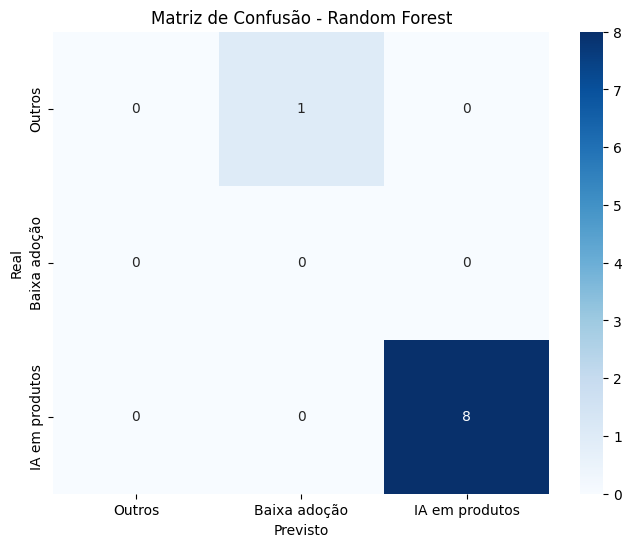


Matriz de Probabilidades (primeiras 10 linhas):
   Prob_Outros  Prob_Baixa adoção  Prob_IA em produtos          Real  \
0     0.000000           0.002500             0.997500        Outros   
1     0.001429           0.005833             0.992738        Outros   
2     0.000000           0.000000             1.000000        Outros   
3     0.246774           0.440655             0.312571  Baixa adoção   
4     0.001667           0.009440             0.988893        Outros   
5     0.021786           0.027250             0.950964        Outros   
6     0.033857           0.090476             0.875667        Outros   
7     0.013333           0.019583             0.967083        Outros   
8     0.009000           0.010750             0.980250        Outros   

         Previsto  
0          Outros  
1          Outros  
2          Outros  
3  IA em produtos  
4          Outros  
5          Outros  
6          Outros  
7          Outros  
8          Outros  
Matriz de probabilidades salva

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

Acurácia média (validação cruzada): 0.9111111111111111


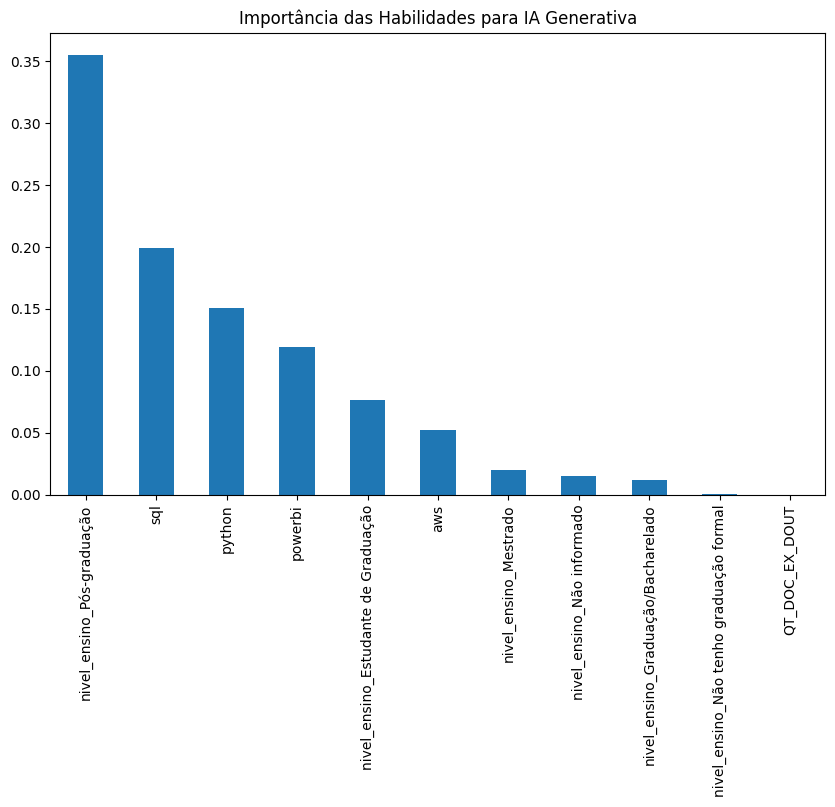

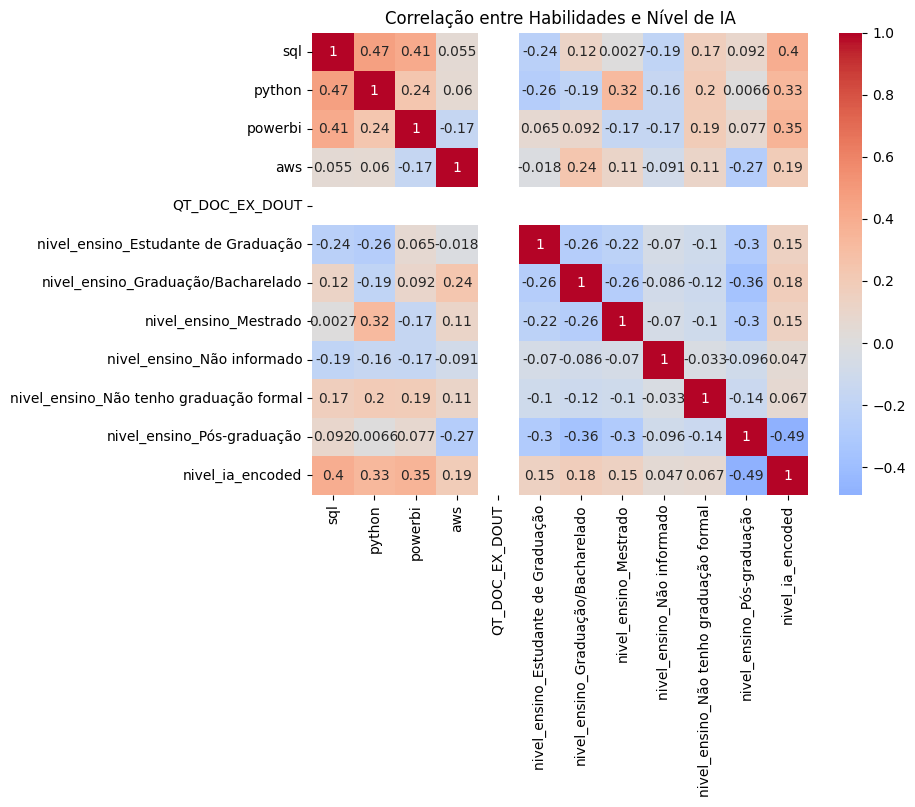

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.tree import export_graphviz

# Carregar os dados
dados = pd.read_csv('dados_processados.csv')
ensino = pd.read_excel('Analise_Ensino_Superior_Consolidada.xlsx')

# Cruzar estado com SG_UF_IES
estado_doutores = ensino.groupby('SG_UF_IES')['QT_DOC_EX_DOUT'].mean().reset_index()
dados = dados.merge(estado_doutores, left_on='estado', right_on='SG_UF_IES', how='left')

# Pré-processamento
dados['nivel_ia'] = dados['nivel_ia'].fillna('Outros')
dados['QT_DOC_EX_DOUT'] = dados['QT_DOC_EX_DOUT'].fillna(dados['QT_DOC_EX_DOUT'].median())

# Codificar nivel_ia
le = LabelEncoder()
dados['nivel_ia_encoded'] = le.fit_transform(dados['nivel_ia'])

# Verificar distribuição das classes
class_counts = dados['nivel_ia_encoded'].value_counts()
print("Distribuição das classes em nivel_ia_encoded:\n", class_counts)

# Filtrar classes com menos de 2 amostras
valid_classes = class_counts[class_counts >= 2].index
dados = dados[dados['nivel_ia_encoded'].isin(valid_classes)]

# Selecionar features
habilidades = ['sql', 'python', 'powerbi', 'aws', 'nivel_ensino', 'QT_DOC_EX_DOUT']
X = dados[habilidades]
y = dados['nivel_ia_encoded']

# Codificar nivel_ensino
X = pd.get_dummies(X, columns=['nivel_ensino'], drop_first=True)

# Dividir os dados
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
except ValueError:
    print("Stratificação falhou. Usando divisão sem estratificação.")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, random_state=42)
rf.fit(X_train, y_train)

# Gerar previsões
y_pred = rf.predict(X_test)

# --- Novos Gráficos ---
# 1. Visualização de uma Árvore da Random Forest
tree = rf.estimators_[0]
dot_data = export_graphviz(tree, out_file=None, feature_names=X.columns,
                           class_names=[str(cls) for cls in le.classes_[valid_classes]],
                           filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph.render("arvore_random_forest", format="png", view=False)
print("Árvore da Random Forest salva como 'arvore_random_forest.png'")

# 2. Curva de aprendizado
train_sizes, train_scores, test_scores = learning_curve(rf, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Acurácia Treino')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Acurácia Teste')
plt.xlabel('Tamanho do Conjunto de Treino')
plt.ylabel('Acurácia')
plt.title('Curva de Aprendizado da Random Forest')
plt.legend()
plt.savefig('curva_aprendizado_rf.png')
plt.show()

# 3. Gráfico de dispersão (tentativa de correção)
# Verificar se python e QT_DOC_EX_DOUT são adequados
if (dados['python'].dtype in [np.float64, np.int64, np.float32, np.int32] and
    dados['QT_DOC_EX_DOUT'].notnull().any() and len(dados) > 0):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=dados, x='python', y='QT_DOC_EX_DOUT', hue='nivel_ia', palette='viridis', alpha=0.6)
    plt.title('Relação entre Python, QT_DOC_EX_DOUT e Nível de IA')
    plt.savefig('dispersao_habilidades.png')
    plt.show()
else:
    print("Gráfico de dispersão não gerado: 'python' ou 'QT_DOC_EX_DOUT' não são adequados (categóricos ou vazios).")

# --- Matriz de Solução ---
# 1. Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_[valid_classes], yticklabels=le.classes_[valid_classes])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Random Forest')
plt.savefig('matriz_confusao_rf.png')
plt.show()

# 2. Matriz de Probabilidades Previstas
probs = rf.predict_proba(X_test)
matriz_probs = pd.DataFrame(probs, columns=[f'Prob_{cls}' for cls in le.classes_[valid_classes]])
matriz_probs['Real'] = [le.classes_[i] for i in y_test]
matriz_probs['Previsto'] = [le.classes_[i] for i in y_pred]
print("\nMatriz de Probabilidades (primeiras 10 linhas):")
print(matriz_probs.head(10))
matriz_probs.to_csv('matriz_probabilidades_rf.csv', index=False)
print("Matriz de probabilidades salva como 'matriz_probabilidades_rf.csv'")

# --- Avaliação do Modelo ---
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred, target_names=le.classes_[valid_classes]))

# Validação cruzada
scores = cross_val_score(rf, X, y, cv=5)
print("Acurácia média (validação cruzada):", scores.mean())

# Importância das features
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Importância das Habilidades para IA Generativa')
plt.savefig('importancia_features_rf.png')
plt.show()

# Análise de correlação
corr_data = X.copy()
corr_data['nivel_ia_encoded'] = y
correlacoes = corr_data.corr(method='spearman')
plt.figure(figsize=(8, 6))
sns.heatmap(correlacoes, annot=True, cmap='coolwarm', center=0)
plt.title('Correlação entre Habilidades e Nível de IA')
plt.savefig('heatmap_correlacao_rf.png')
plt.show()